In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import pandas as pd
import urllib.request
import numpy as np
import matplotlib as plt
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print('Loading merged data ...')
mutations_raw = pd.read_csv("pancancer_mutations_merged.csv", 
                        usecols=['cancer_type', 'bcr_patient_barcode', 'Hugo_Symbol', 'BIOTYPE'])
print("done.")
print("Mutations count", mutations_raw['bcr_patient_barcode'].count())

Loading merged data ...
done.
Mutations count 3570876


In [4]:
mutations_raw.head()

,Hugo_Symbol,BIOTYPE,cancer_type,bcr_patient_barcode
0,TACC2,protein_coding,GBM,TCGA-02-0003
1,JAKMIP3,protein_coding,GBM,TCGA-02-0003
2,PANX3,protein_coding,GBM,TCGA-02-0003
3,SPI1,protein_coding,GBM,TCGA-02-0003
4,NAALAD2,protein_coding,GBM,TCGA-02-0003


In [5]:
mutations = mutations_raw[mutations_raw['BIOTYPE'] == 'protein_coding']
mutations_non_coding_genes = mutations_raw[mutations_raw['BIOTYPE'] != 'protein_coding']

coding_genes = list(mutations['Hugo_Symbol'].unique())
non_coding_genes = list(mutations_non_coding_genes['Hugo_Symbol'].unique())
print("Number of coding genes:", len(coding_genes))
print("Number of non-coding genes:", len(non_coding_genes))
                                  



Number of coding genes: 19209
Number of non-coding genes: 2140


Genes by patient frequency
  mean: 141
  min:  1
  max:  3879


,gene,patient_count
17222,TP53,3879
17606,TTN,3781
10315,MUC16,2415
3983,CSMD3,1610
14415,RYR2,1594
16203,SYNE1,1538
9210,LRP1B,1514
12362,PIK3CA,1428
6089,FLG,1399
17924,USH2A,1378


Text(0.5, 0, 'Number of Genes')

Text(0, 0.5, 'Number of Patient Tumors (gene is present in)')

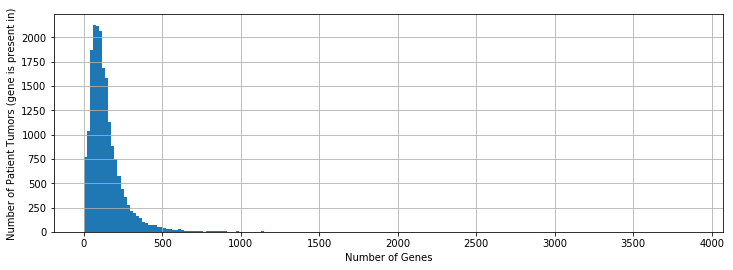

In [6]:
# Show the distribution of genes across patient tumors
gene_count = mutations.groupby(['Hugo_Symbol'])['bcr_patient_barcode'].nunique().reset_index(name='count')
gene_count.columns = ['gene', 'patient_count']
gene_count = gene_count.sort_values(['patient_count', 'gene'], ascending=[0,1])
print('Genes by patient frequency')
print("  mean:", int(gene_count['patient_count'].mean()))
print("  min: ", int(gene_count['patient_count'].min()))
print("  max: ", int(gene_count['patient_count'].max()))
gene_count.head(10)

ax = gene_count['patient_count'].hist(bins=200, figsize=(12,4))
ax.set_xlabel("Number of Genes")
ax.set_ylabel("Number of Patient Tumors (gene is present in)")


Number of cancer types 32
['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD' 'PCPG'
 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC' 'UCS'
 'UVM']

Number of patients 10008


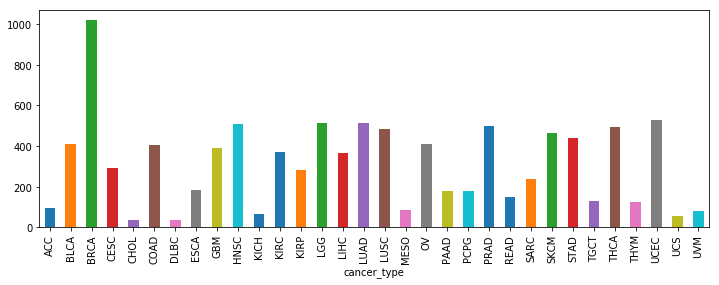

In [7]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))
print(np.sort(cancer_types))

# Get number of cases per cancer type
group_patients_by_cancer = mutations.groupby(['cancer_type'])['bcr_patient_barcode'].nunique()
print("\nNumber of patients", group_patients_by_cancer.sum())
group_patients_by_cancer.plot.bar(figsize=(12,4))

Mean number of genes represented for each cancer type: 11831
Min number of genes represented for each cancer type: 1606
Max number of genes represented for each cancer type: 19090


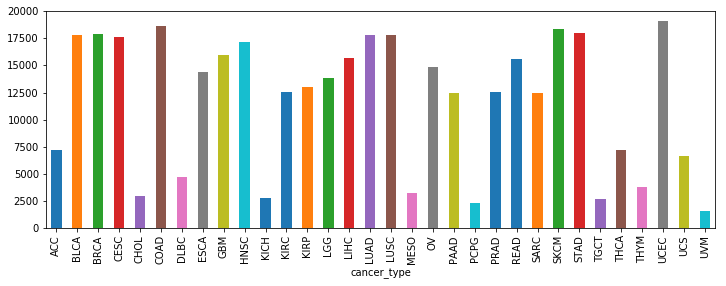

In [8]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations.groupby(['cancer_type'])['Hugo_Symbol'].nunique();
group_genes_by_cancer.plot.bar(figsize=(12,4))
print("Mean number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.mean())))
print("Min number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.min())))
print("Max number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.max())))

In [9]:
# Write out a matrix; each row is a patient tumor; each column is a gene
def saveFeatureMatrix(mutations, feature_genes, gene_count):
    cases = list()
    grouped = mutations.groupby('bcr_patient_barcode')
    i = int(0)

    cols = ['case_id', 'cancer_type']
    for gene in feature_genes:
        cols.append(gene)


    for name, group in grouped:
        case = list()
        case.append(name)
        for cc in group.cancer_type.head(1):
            case.append(cc)

        for gene_flag  in feature_genes.isin(group.Hugo_Symbol.unique()):
            switch = 0
            if gene_flag == True:
                switch = 1
            case.append(switch)
        cases.append(case)


    cases_df = pd.DataFrame(cases)
    cases_df.columns = cols
    print("  number of rows in full dataset", cases_df.case_id.count())
    
    # Write out transformed data to csv
    fileName = "pancancer_case_features_" + str(gene_count) + ".csv"
    print("  writing", fileName, "...")
    cases_df.to_csv(fileName)
    print("  done.")


In [10]:
def showGenesAcrossCancerTypes(top_gene_cancer_matrix, top_n_gene_count, total_gene_count):
    plt.rcParams["figure.figsize"] = (20,4)
    sums_by_cancer_type = top_gene_cancer_matrix.sum(axis=1, skipna=True, numeric_only=True) 
    sorted = sums_by_cancer_type.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'patient_count']
    df.reset_index()    
    title = 'Patient counts for genes (top ' + str(top_n_gene_count) + ')';
    ax = df.head(50).plot.bar(x='gene', y='patient_count', legend=None, title=title)




In [11]:

def createFeatureMatrix(top_n_gene_count):
    print("Formatting gene matrix with top ", top_n_gene_count, "genes from each cancer type")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations.groupby(['cancer_type', 'Hugo_Symbol'])['bcr_patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)


    # Now find the top n genes for each cancer type
    top_genes = []
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        top_rows = sorted_genes[sorted_genes > 0].head(top_n_gene_count)
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is gene, column for each cancer type
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    print("  number of genes:", top_gene_cancer_matrix.shape[0])
    showGenesAcrossCancerTypes(top_gene_cancer_matrix, top_n_gene_count, top_gene_cancer_matrix.shape[0] )
    feature_genes = top_gene_cancer_matrix.index
    saveFeatureMatrix(mutations, feature_genes, top_n_gene_count)

In [ ]:
createFeatureMatrix(100)
createFeatureMatrix(250)
createFeatureMatrix(500)
createFeatureMatrix(800)

Formatting gene matrix with top  1500 genes from each cancer type
  number of genes: 11194
  number of rows in full dataset 10008
  writing pancancer_case_features_1500.csv ...
  done.


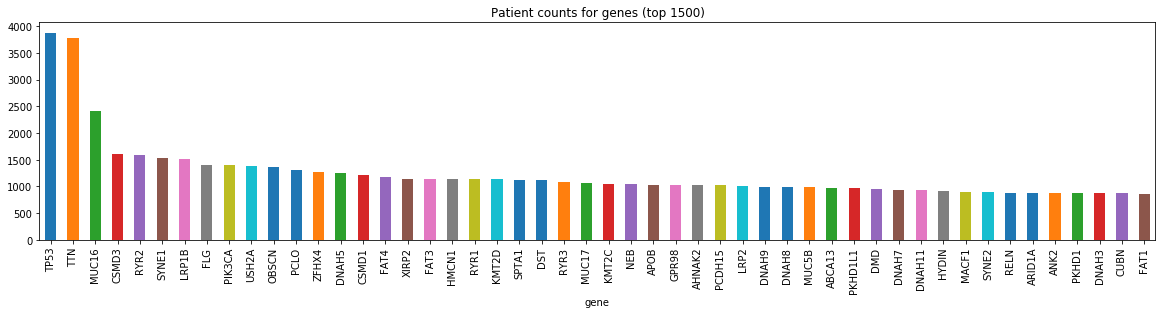

In [12]:
createFeatureMatrix(1500)